In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [60]:
#load data
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test)=mnist.load_data()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


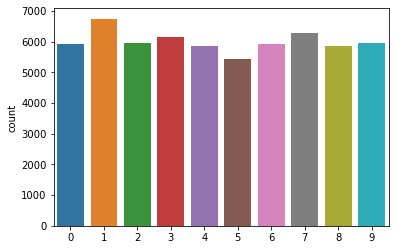

In [61]:
g = sns.countplot(y_train)

5


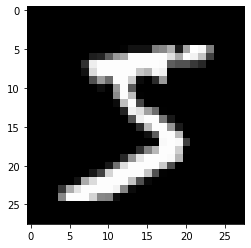

In [62]:
plt.figure()

plt.imshow(x_train[0],cmap='gray')
print(y_train[0])

In [43]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [44]:
# Normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0

In [72]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_train = to_categorical(y_train, num_classes = 10)
y_test=to_categorical(y_test, num_classes = 10)

In [46]:
y_train.shape

(60000, 10)

In [47]:
# Set the random seed
random_seed = 2

In [48]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed)

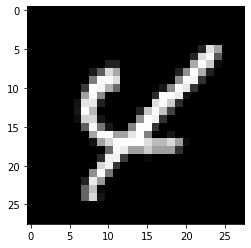

In [50]:
# Some examples
g = plt.imshow(X_train[0][:,:,0],cmap='gray')

# Define the model CNN

In [51]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [53]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [54]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [55]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [65]:
epochs = 3 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [66]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [67]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/3


C:\Users\omar gamel\AppData\Local\Temp\ipykernel_14516\923181679.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),


627/627 - 202s - loss: 0.1096 - accuracy: 0.9682 - val_loss: 0.0340 - val_accuracy: 0.9890 - lr: 0.0010 - 202s/epoch - 321ms/step
Epoch 2/3
627/627 - 193s - loss: 0.0835 - accuracy: 0.9763 - val_loss: 0.0348 - val_accuracy: 0.9892 - lr: 0.0010 - 193s/epoch - 307ms/step
Epoch 3/3
627/627 - 185s - loss: 0.0724 - accuracy: 0.9790 - val_loss: 0.0362 - val_accuracy: 0.9903 - lr: 0.0010 - 185s/epoch - 296ms/step


In [68]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  #plt.ylim([0,.9])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()
  plt.show()

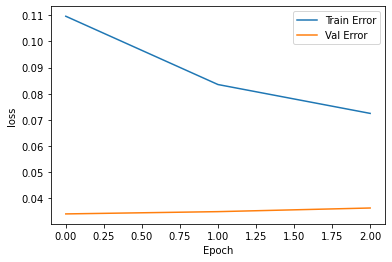

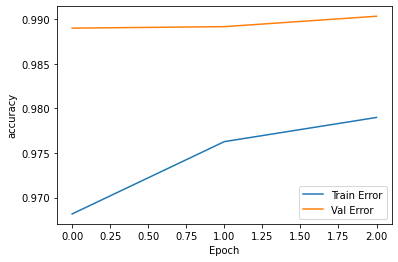

In [69]:
plot_history(history)

In [73]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 5s 16ms/step - loss: 6.3070 - accuracy: 0.9906


[6.3069634437561035, 0.9905999898910522]